# Wine Quality: Regression

Predict wine quality<sup>1</sup> from physicochemical properties.

<small>[1] Modeling wine preferences by data mining from physicochemical properties. P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Decision Support Systems, Elsevier, 47(4):547-553, 2009.</small>

1. Get Data.
2. Interpret the feature correlation matrix.
3. Implement linear and nonlinear models.
4. Compare and choose between linear and nonlinear models.
5. Optimize the chosen model.
6. Debug the chosen model.

## Import required packages

In [2]:
# Reset environment for a new run
% reset -f

In [3]:
# For joining file pathnames
from os.path import join 

# For Dataframe
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# For plotting
import numpy as np
import matplotlib.pyplot as plt

# For correlation
import seaborn as sns

# For model
import tensorflow as tf
from tensorflow import keras

## Get Data

[Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality), hosted at UCI, contains data on the physicochemical properties of wine along with wine quality ratings (0-10).

In [4]:
wineDf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/winequality.csv", encoding='latin-1')

wineDf.columns = [
    'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide',
    'total sulfur dioxide','density','pH','sulphates','alcohol','quality'
  ]

wineDf

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.3,0.4,20.7,0.0,45.0,170.0,1.0,3.0,0.5,8.8,6
1,6.3,0.3,0.3,1.6,0.0,14.0,132.0,1.0,3.3,0.5,9.5,6
2,8.1,0.3,0.4,6.9,0.1,30.0,97.0,1.0,3.3,0.4,10.1,6
3,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
4,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.6,0.1,2.0,0.1,32.0,44.0,1.0,3.5,0.6,10.5,5
6493,5.9,0.6,0.1,2.2,0.1,39.0,51.0,1.0,3.5,0.8,11.2,6
6494,6.3,0.5,0.1,2.3,0.1,29.0,40.0,1.0,3.4,0.8,11.0,6
6495,5.9,0.6,0.1,2.0,0.1,32.0,44.0,1.0,3.6,0.7,10.2,5


## Check Feature Correlation Matrix

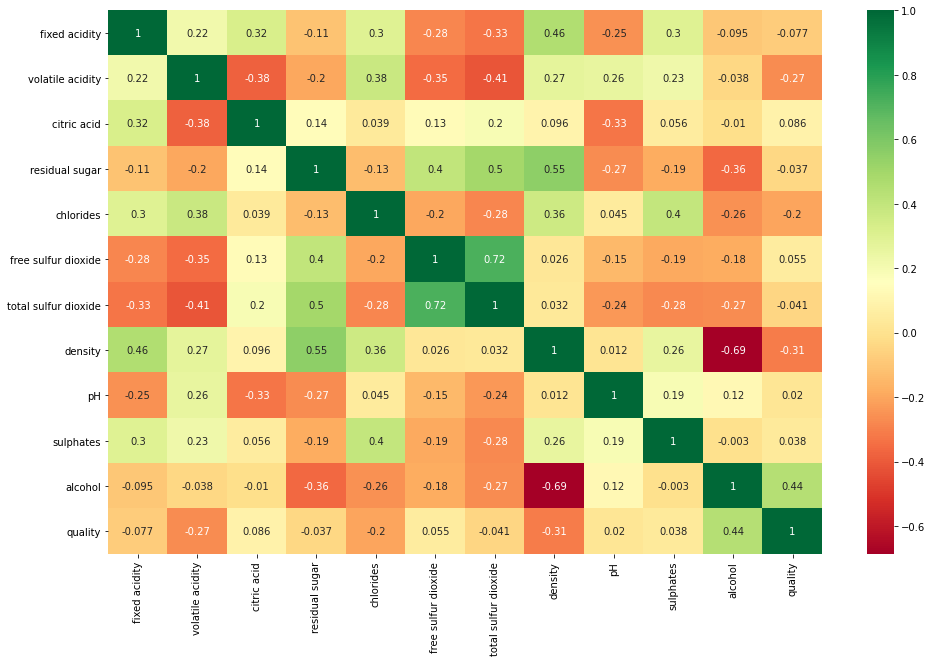

In [5]:
corr_wineDf = wineDf.corr()

plt.figure(figsize=(16,10))
sns.heatmap(corr_wineDf, cmap='RdYlGn', annot=True)

Features correlations:
* `alcohol` is most highly correlated with `quality` . 
* `volatile acidity` correlates with `quality` but not with `alcohol`, making it a good second feature. 

Note: Correlation matrix is not helpful if predictive signals are encoded in combinations of features.

## Explore the Data Statistics

In [6]:
wineDf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0
mean,7.2,0.3,0.3,5.4,0.1,30.5,115.7,1.0,3.2,0.5,10.5,5.8
std,1.3,0.2,0.1,4.8,0.0,17.7,56.5,0.0,0.2,0.1,1.2,0.9
min,3.8,0.1,0.0,0.6,0.0,1.0,6.0,1.0,2.7,0.2,8.0,3.0
25%,6.4,0.2,0.2,1.8,0.0,17.0,77.0,1.0,3.1,0.4,9.5,5.0
50%,7.0,0.3,0.3,3.0,0.0,29.0,118.0,1.0,3.2,0.5,10.3,6.0
75%,7.7,0.4,0.4,8.1,0.1,41.0,156.0,1.0,3.3,0.6,11.3,6.0
max,15.9,1.6,1.7,65.8,0.6,289.0,440.0,1.0,4.0,2.0,14.9,9.0


## Define the Data Schema

Using the data statistics, define the data schema.

For demonstration purposes, restrict your data schema to the first three data columns. 

For each data column:

* minimum value
* maximum value
* data type

In [7]:
wine_schema = {
    'fixed acidity': {
        'range': {
            'min': 3.7,
            'max': 15.9
        },
        'dtype': float,
    },
    'volatile acidity': {
        'range': {
            'min': 0.08,
            'max': 1.6
        },
        'dtype': float,
    },
    'citric acid': {
        'range': {
            'min': 0.0,
            'max': 1.7
        },
        'dtype': float,
    },
    'residual sugar': {
        'range': {
            'min': 0.6,
            'max': 65.8
        },
        'dtype': float,
    },
    'chlorides': {
        'range': {
            'min': 0.0,
            'max': 0.62
        },
        'dtype': float,
    },
    'free sulfur dioxide': {
        'range': {
            'min': 1.0,
            'max': 289.0
        },
        'dtype': float,
    },
    'total sulfur dioxide': {
        'range': {
            'min': 6.0,
            'max': 440.0
        },
        'dtype': float,
    },
    'density': {
        'range': {
            'min': 0.8,
            'max': 1.2
        },
        'dtype': float,
    },
    'pH': {
        'range': {
            'min': 2.7,
            'max': 4.2
        },
        'dtype': float,
    },
    'sulphates': {
        'range': {
            'min': 0.2,
            'max': 2.0
        },
        'dtype': float,
    },
    'alcohol': {
        'range': {
            'min': 8.0,
            'max': 14.9
        },
        'dtype': float,
    }
}

## Validate Input Data against Data Schema

In [8]:
def test_data_schema(input_data, schema):
  """
  Tests data adherence to expectations
    datatypes
    ranges of values
  Args:
    input_data: Dataframe containing data to test
    schema: Schema which describes the properties of the data
  """

  def test_dtypes():
    for column in schema.keys():
      # Assert that the data type is correct as per the schema
      assert input_data[column].map(type).eq(schema[column]['dtype']).all(), ("Incorrect dtype in column '%s'." % column)
    print('Input dtypes are correct.')

  def test_ranges():
    for column in schema.keys():
      schema_max = schema[column]['range']['max']
      schema_min = schema[column]['range']['min']
      # Assert that data falls between min and max ranges as per the schema
      assert input_data[column].max() <= schema_max, ("Maximum value of column '%s' is too low." % column)
      assert input_data[column].min() >= schema_min, ("Minimum value of column '%s' is too high." % column)
    print('Data falls within specified ranges.')

  test_dtypes()
  test_ranges()

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

Validating wine data against data schema...
Input dtypes are correct.
Data falls within specified ranges.


## Normalize Feature Data

### Split the dataset into data and labels

In [9]:
features = wineDf.copy(deep=True)
features.drop(columns='quality',inplace=True)

labels = wineDf['quality'].copy(deep=True)

### Normalize features using z-score

In [10]:
def normalize(x):
  std_x = np.std(x)
  mean_x = np.mean(x)
  norm_x = (x - mean_x) / std_x
  return norm_x

for x in features.columns:
   features[x] = normalize(features[x])

## Test Engineered Feature Data

Test the engineered data for errors:
* the data has the expected number of rows and columns.
* the data not have null values.

In [11]:
import unittest

def test_input_dim(df, n_rows, n_columns):
  assert len(df) == n_rows, "Unexpected number of rows."
  assert len(df.columns) == n_columns, "Unexpected number of columns."
  print('Engineered data has the expected number of rows and columns.')

def test_nulls(df):
  nulls = df.isnull().sum().sum()
  assert nulls == 0, "Nulls in engineered data."
  print('Engineered features do not contain nulls.')

### Check for expected  dimension

Verify that input data had 6497 examples and 11 feature columns. The test should fails if you change the values below.

In [12]:
feature_rows = 6497 #@param
feature_cols = 11 #@param
test_input_dim(features, feature_rows, feature_cols)

Engineered data has the expected number of rows and columns.


### Check for nulls

Test that your engineered data does not contain nulls.

In [13]:
test_nulls(features)

Engineered features do not contain nulls.


## Create train and validation sets with Statistical Equivalence

Check that the training and validation splits are equally representative. 
* Assume a training:validation split of 80:20
* Compare the mean and the standard deviation of the splits.

### Split data to training and validation sets

In [14]:
splitIdx = int(features.shape[0]*0.8)
features_train = features.iloc[0:splitIdx,:]
features_valid = features.iloc[splitIdx:-1,:]

### Check training data statistics

In [15]:
features_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0
mean,-0.2,-0.3,0.1,0.2,-0.2,0.2,0.3,-0.2,-0.1,-0.2,-0.0
std,0.7,0.8,0.9,1.1,0.9,1.0,0.8,1.0,1.0,0.9,1.0
min,-2.6,-1.6,-2.2,-1.0,-1.3,-1.6,-1.9,-2.5,-3.1,-2.1,-2.1
25%,-0.7,-0.8,-0.4,-0.8,-0.6,-0.5,-0.2,-1.0,-0.8,-0.8,-0.9
50%,-0.3,-0.4,-0.1,-0.1,-0.3,0.1,0.3,-0.2,-0.2,-0.3,-0.2
75%,0.1,0.0,0.5,0.9,-0.1,0.8,0.9,0.6,0.4,0.2,0.7
max,6.0,6.0,9.2,12.7,15.8,14.6,5.7,14.8,4.2,9.9,3.1


### Check validation data statistics

In [16]:
features_valid.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0
mean,0.9,1.1,-0.3,-0.6,0.8,-0.8,-1.3,0.7,0.6,0.8,0.0
std,1.4,1.1,1.3,0.3,1.1,0.6,0.6,0.7,1.0,1.0,0.9
min,-1.8,-1.3,-2.2,-1.0,-1.3,-1.7,-1.9,-1.5,-2.2,-1.1,-1.8
25%,-0.1,0.3,-1.5,-0.7,0.4,-1.3,-1.7,0.3,-0.1,0.1,-0.7
50%,0.6,1.0,-0.3,-0.7,0.7,-0.9,-1.4,0.7,0.5,0.6,-0.1
75%,1.7,1.8,0.8,-0.6,1.0,-0.5,-1.0,1.1,1.1,1.3,0.7
max,6.7,7.5,3.2,2.1,10.4,2.3,3.1,3.0,4.9,7.3,3.7


The two splits are clearly not equally representative. To make the splits equally representative, you can shuffle the data.

### Make the splits statistically equivalent

* shuffle the data
* recreate the features and labels
* normalize the features

In [17]:
# Shuffle data
shuffled_df = wineDf.sample(frac=1).reset_index(drop=True)

# Recreate features and labels
features = shuffled_df.copy(deep=True)
features.drop(columns='quality',inplace=True)
labels = shuffled_df['quality'].copy(deep=True)

# Normalize
for x in features.columns:
   features[x] = normalize(features[x])

# Split into training and validation sets
splitIdx = int(features.shape[0]*0.8)
features_train = features.iloc[0:splitIdx,:]
features_valid = features.iloc[splitIdx:-1,:]

* Re-check training and validation data statistics

In [18]:
features_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0
mean,-0.2,-0.3,0.1,0.2,-0.2,0.2,0.3,-0.2,-0.1,-0.2,-0.0
std,0.7,0.8,0.9,1.1,0.9,1.0,0.8,1.0,1.0,0.9,1.0
min,-2.6,-1.6,-2.2,-1.0,-1.3,-1.6,-1.9,-2.5,-3.1,-2.1,-2.1
25%,-0.7,-0.8,-0.4,-0.8,-0.6,-0.5,-0.2,-1.0,-0.8,-0.8,-0.9
50%,-0.3,-0.4,-0.1,-0.1,-0.3,0.1,0.3,-0.2,-0.2,-0.3,-0.2
75%,0.1,0.0,0.5,0.9,-0.1,0.8,0.9,0.6,0.4,0.2,0.7
max,6.0,6.0,9.2,12.7,15.8,14.6,5.7,14.8,4.2,9.9,3.1


In [19]:
features_valid.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0
mean,0.9,1.1,-0.3,-0.6,0.8,-0.8,-1.3,0.7,0.6,0.8,0.0
std,1.4,1.1,1.3,0.3,1.1,0.6,0.6,0.7,1.0,1.0,0.9
min,-1.8,-1.3,-2.2,-1.0,-1.3,-1.7,-1.9,-1.5,-2.2,-1.1,-1.8
25%,-0.1,0.3,-1.5,-0.7,0.4,-1.3,-1.7,0.3,-0.1,0.1,-0.7
50%,0.6,1.0,-0.3,-0.7,0.7,-0.9,-1.4,0.7,0.5,0.6,-0.1
75%,1.7,1.8,0.8,-0.6,1.0,-0.5,-1.0,1.1,1.1,1.3,0.7
max,6.7,7.5,3.2,2.1,10.4,2.3,3.1,3.0,4.9,7.3,3.7


Now, the splits are equally representative. It turns out that in the wine dataset, the first 4897 rows contain data on white wines and the next 1599 rows contain data on red wines. When you split your dataset 80:20, then your training dataset contains 5197 examples, which is 94% white wine. The validation dataset is purely red wine. 

## Establish a Baseline

For a regression problem, the simplest baseline is to predict the average value. 
* Calculate the mean-squared error (MSE) loss on the training split using the average value as a baseline.

In [22]:
baselineMSE = np.square(labels[0:splitIdx] - np.mean(labels[0:splitIdx]))
baselineMSE = np.sum(baselineMSE)/len(baselineMSE)
print(baselineMSE)

0.7644705103434956


## Model

In [53]:
# Loss Curve plotting fucntion
def showRegressionResults(trainHistory):
  """Function to:
   * Print final loss.
   * Plot loss curves.
  
  Args:
    trainHistory: object returned by model.fit
  """
  epochs = len(trainHistory.history['loss'])
  
  # Print final loss
  print("Final training loss: " + str(trainHistory.history['loss'][-1]))
  print("Final Validation loss: " + str(trainHistory.history['val_loss'][-1]))
  
  # Plot loss curves
  plt.plot(trainHistory.history['loss'])
  plt.plot(trainHistory.history['val_loss'])
  plt.legend(['Training loss','Validation loss'],loc='best')
  plt.title('Loss Curves')
  plt.xlabel('Epoch')
  plt.xticks(np.arange(0, epochs+1, step=5))

### 1. Linear model
* Start with a linear model
* Uses the **most informative feature** from the correlation matrix: `alcohol`.
* Use **full batch** 
* Use it as a baseline. 
* This model **should beat our previous baseline's MSE** of 0.76.

Final training loss: 29.024845123291016
Final Validation loss: 29.249027252197266


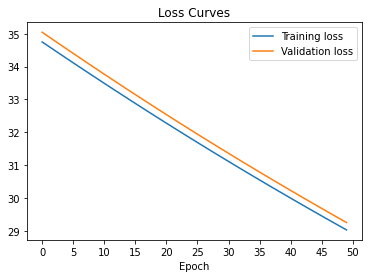

In [44]:
model = None
model = keras.Sequential()
# Linear model
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
# Train the model with most informative feature
informativeFeature = features['alcohol']
trainHistory = model.fit(informativeFeature, labels, 
                         epochs=50, 
                         batch_size=len(features), # full batch per epoch to update the gradient only once per epoch
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

The loss decreases but very slowly. Possible fixes are:

* Increase number of epochs.
* Increase learning rate.
* Decrease batch size. A lower batch size can result in larger decrease in loss per epoch, under the assumption that the smaller batches stay representative of the overall data distribution.

### 2. Optimize Linear model
* a **reduced batch size** of 100. Reducing the batch size leads to a greater decrease in loss per epoch. The minimum achievable loss is about 0.64. This is a significant increase over our baseline of 0.75.

Final training loss: 0.7057306170463562
Final Validation loss: 0.7091871500015259


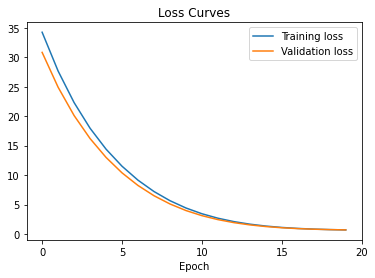

In [45]:
model = None
model = keras.Sequential()
# Linear model
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
# Train the model with most informative feature
informativeFeature = features['alcohol']
trainHistory = model.fit(informativeFeature, labels, 
                         epochs=20, 
                         batch_size=100, # reduced batch size
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

### Further Optimized Linear model

* **Add more feature**: `volatile acidity`
* **Add a second hidden linear layer** with 1 unit.
* **Experiment with learning rate, epochs, and batch_size** to try to reduce loss.

Final training loss: 0.5662139654159546
Final Validation loss: 0.5727726221084595


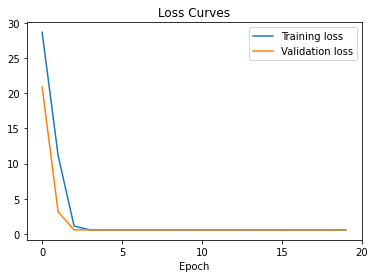

In [47]:
model = None
model = keras.Sequential()
# Selected features
selectedFeatures = features[['alcohol', 'volatile acidity']] # add second feature
# Linear model
model.add(keras.layers.Dense(selectedFeatures.shape[1], activation='linear', input_dim=selectedFeatures.shape[1]))
model.add(keras.layers.Dense(1, activation='linear')) # second layer
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
# Train
trainHistory = model.fit(selectedFeatures, labels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

Loss decreases a little bit from previous model

### Nonlinear Model

* Change the first layer to use `relu`. (Output layer stays linear since this is a regression problem.)
* As usual, **experiment with the learning rate, epochs, and batch_size**.

Final training loss: 0.5662139654159546
Final Validation loss: 0.5727726221084595


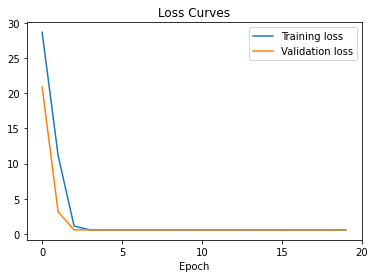

In [48]:
model = None
model = keras.Sequential()
# Non Linear
model.add(keras.layers.Dense(selectedFeatures.shape[1], activation='relu', input_dim=selectedFeatures.shape[1]))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train
model.fit(selectedFeatures, labels,
          epochs=20,
          batch_size=100,
          validation_split=0.2,
          verbose=0)
# Plot results
showRegressionResults(trainHistory)

The loss stays about the same, perhaps declining negligibly.

### Optimize Non Linear Model 

We have two features with one hidden layer but didn't see an improvement.
* **Add next 2 high corr features**: `density` and `chlorides`
* **Increase training epochs** to 100.
* **Experiment with batch size** = 100.

Final training loss: 0.5681012868881226
Final Validation loss: 0.5740871429443359


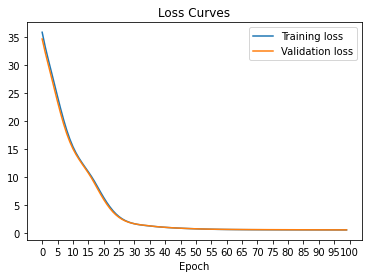

In [50]:
# Choose features
selectedFeatures = features[['alcohol', 'volatile acidity', 'density', 'chlorides']]
# Non Linear model
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(selectedFeatures.shape[1],
                             activation='relu',
                             input_dim=selectedFeatures.shape[1]))
# Add more layer
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train
trainHistory = model.fit(selectedFeatures,
                         labels,
                         epochs=100,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

It seems that adding more features or capacity isn't improving your model by much. Perhaps your model has a bug? Need to run a sanity check on the model.

### Check for Implementation Bugs using Reduced Dataset

* Use a **reduced dataset** (10 examples). 
* **Experiment with the learning rate, batch size, and number of epochs**, that let you iterate quickly.
* Obtain a low loss

Final training loss: 0.5558727383613586


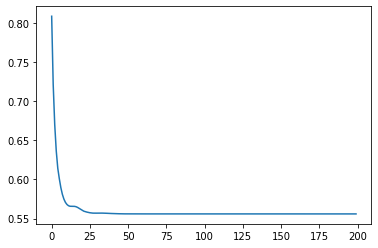

In [52]:
# Choose 10 examples
featuresSmall = features[0:10]
labelsSmall = features[0:10]
# Define Non Linear model
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(featuresSmall.shape[1], activation='relu', input_dim=featuresSmall.shape[1]))
model.add(keras.layers.Dense(featuresSmall.shape[1], activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
# Train
trainHistory = model.fit(featuresSmall, labelsSmall,
                        epochs=200,
                        batch_size=10,
                        verbose=0)
# Plot results
print("Final training loss: " + str(trainHistory.history['loss'][-1]))
plt.plot(trainHistory.history['loss'])

We get a low loss on the reduced dataset using:
* learning rate = 0.01
* epochs = 200
* batch size = 10

=> The model is probably solid and the previous results are as good as they'll get.

### Very Complex Non Linear Model

Final training loss: 0.46691688895225525
Final Validation loss: 0.49237337708473206


(0.4, 1.0)

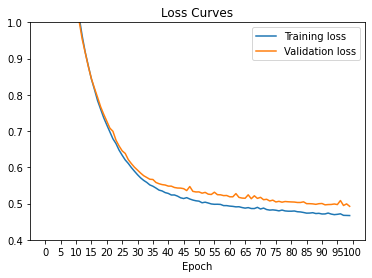

In [56]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(features.shape[1], activation='relu', input_dim=features.shape[1]))
model.add(keras.layers.Dense(features.shape[1], activation='relu'))
model.add(keras.layers.Dense(features.shape[1], activation='relu'))
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train the model!
trainHistory = model.fit(features, labels, 
                         epochs=100, 
                         batch_size=100,
                         validation_split = 0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)
plt.ylim(0.4,1)

After 100 epochs, the minimum achievable MSE is around 0.46, which is a 0.1 decrease from the previous best loss of 0.56. This decrease probably isn't worth the performance and complexity cost of using all your features and a deeper network. However, that decision depends on the objectives you're optimizing for.

If you train the model long enough, the validation loss actually starts increasing while training loss continues to decrease. This divergence in loss curves means your model is overfitting. The overfitting results from the closer fit that your very complex model can learn. Stick with the simpler model. You'll be happier and live longer!

If you do want to optimize your loss, then play with the model to find the minimum achievable training loss before overfitting sets in. Try playing with the network parameters in the code cell above to achieve a loss of 0.51. But be warned—optimizing your loss could take a lot of trial and error..

## Conclusion

Principles:

* The most important step in machine learning is understanding your data.
* The largest gains come from the initial features and network.
* Returns diminish as you add features and complexity.
* Incremental development provides confidence in model quality and allows benchmarking against previous results.
* Reproducing previous results is extremely important. Hence, always use version control.